# TP : Résolution de l'équation de Vlasov-Poisson 1D-1D par une méthode semi-lagrangienne

In [73]:
# Basic imports 
import numpy as np 
import matplotlib.pyplot as plt 

On s'intéresse à l'équation de Vlasov  (évolution de la distribution des électrons dans un plasma) couplée avec l'équation de Poisson (évolution du champ électrique). 

\begin{equation}
\begin{cases}
\partial_t f + v \,\partial_x f - E(x,t) \,\partial_v f = 0 \\ 
\\ 
\partial_x E = \rho(x,t) = 1 - \int f(x,v,t) \,dv 
\end{cases}
\end{equation} 


## Discrétisation de l'espace des phases 

On considère un espace des phases en deux dimensions (une d'espace et une de vitesse) $\Omega = (-\pi, \pi)^2 \subset \mathbb{R}^2$ que l'on va discrétiser par une grille uniforme $\mathcal{M} = \{(x_i, v_j)\}_{i= 0\,, \cdots, \,n_x-1\,,\,j=0\,, \cdots,\, n_v-1, }\subset \Omega$ 

In [377]:
nx = 200; nv = 200
dx = 2*np.pi / (nx) ; dv =2*np.pi / (nv)
dt = 1e-2
a = np.pi   
x = np.linspace(-a, a, num=nx, dtype=float)
v = np.linspace(-a, a, num=nv, dtype=float)
xx, vv = np.meshgrid(x,v) 

## Condition initiale 

On se donne une condition initiale en distribution de particules $f_0(x,v)$ 

In [378]:
f = lambda x, v : (1 / 2*np.pi)*np.exp(-0.5*(x**2+v**2))

Text(0, 0.5, '$v$')

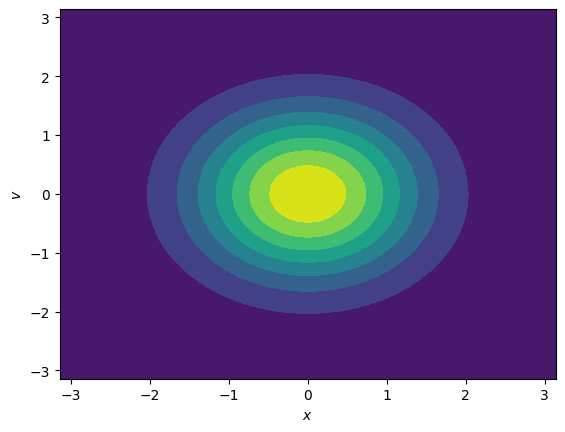

In [379]:

f_zero = f(xx, vv)
plt.contourf(x, v, f_zero)
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')  

## Résolution de  l'équation de Poisson

La partie poisson du problème s'écrit 

\begin{equation}
\tag{P}
\partial_x E = \rho(x,t) = 1 - \int f(x, v, t) \,\text{d}v
\end{equation}

On va résoudre ce problème en discrétisant $f$ en modes de Fourier selon 
$$ f^n(x,v) = f(x,v, t_n) = \frac{1}{2\pi} \sum\limits_{k,l} c^n_{k,l} \, e^{i k.x} e^{i l.v} $$
Ainsi 
\begin{align*}
\rho^n(x, v) & = 1 - \frac{1}{2\pi} \sum\limits_{k,l} c^n_{k,l} \, e^{i k.x} \underbrace{\int e^{i l.v} \,\text{d}v}_{=0 \text{ si } l\neq 0 \text{ et } 2\pi \text{ sinon}} \\ 
             & = 1 - \sum\limits_{k} c^n_{k,0} \, e^{i k.x}  \\ 
             & = \sum\limits_{k} \tilde{c_k}^n \, e^{i k.x},         
\end{align*}
en posant $$\tilde{c_k}^n = 
            \begin{cases} 
                1 - c^n_{k,0} & \text { si } k=0 \\
                - c^n_{k,0} & \text{ sinon.}
            \end{cases} 
            $$
On écrit la somme de Fourier pour le champ électrique : 
$$ E^n(x) = \frac{1}{2\pi} \sum\limits_{j} d_j^n \, e^{i j.x} $$ 
donc 
$$ \frac{\text{d} E^n}{\text{d} x} = \frac{1}{2\pi} \sum\limits_{j} i j\, d_j^n \, e^{i j.x} $$

et par identification (unicité) des coefficients de Fourier on obtient $d_k^n = \frac{\tilde{c_k}^n}{ik} \text{ pour } k\neq 0$. La valeur de $d_0^n$ qui correspond à la moyenne du champ électrique peut être choisie librement et on prendra par exemple $d_0^n=0$.

## Calcul des coefficients de fourier et approximation de la série 

On considère une fonction $f$ $2\pi$-périodique définie sur $(-\pi, \pi)$ d'une variable $x$ 1D dont on cherche à calculer les coefficients de Fourier seulement à partir de sa connaissance sur une grille discrétisée $\{x_l\}_{l=0, \,\cdots,\, n_x-1}$.

Le $k$-ème coefficient de Fourier de $f$ noté $c_k$ est défini par 

$$ c_k = \int_{-\pi}^{\pi} f(x) e^{-ikx} \text{d}x .$$ 

Nous allons approcher ces coefficients à partir de notre discrétisation de l'espace des phases en $x$ avec une somme de Riemman selon : 

$$ c_k^{n_x}= \frac{2\pi}{n_x}\sum\limits_{l=0}^{n_x-1} f_l \, e^{-ik\,x_l} \underset{n_x \to +\infty}{\longrightarrow} c_k .$$ 

Avec $\frac{2\pi}{n_x} = \Delta x$, l'incrément en $x$.

La fonction $f$ est donc approchée par sa série de fourier (où les coefficients de Fourier sont approchés selon ce qui précède) 

$$ f(x) \sim \sum\limits_{k\in\mathbb{Z}} c_k^{n_x} \,e^{ik.x}. $$ 

On introduit ainsi une nouvelle étape de discrétisation en tronquant cette somme de Fourier afin de reconstruire la fonction numériquement. Soit donc $K\in \mathbb{N}^*$ tel qu'on fait l'approximation 

$$ f(x) \sim \sum\limits_{k = -K}^{K} c_k^{n_x} \, e^{ik.x}.$$ 


In [320]:
K = 50
k_values = np.arange(-K, K+1)


On s'intéresse ainsi au calcul des coefficients $c_k$ pour $k= -K, \,\cdots,\, K$ et l'on voit que l'on peut écrire le calcul sous forme matricielle selon : 

 
$$
\begin{pmatrix}
c_{-K} \\
\vdots \\ 
c_{K}
\end{pmatrix}
= 
\frac{2\pi}{n_x} 
\tilde{F}
\begin{pmatrix}
f_0 \\ 
\vdots \\ 
f_{n_x -1} 
\end{pmatrix}
,
$$

Où $\tilde{F}\in \mathbb{R}^{(2K + 1) \times n_x}$ est la matrice définie par 
$$ \tilde{F} = [ \,e^{-ik\,x_l}\, ]_{k = \, -K, \cdots, \,K ;\, l=\,0, \cdots,\, n_x-1}.$$ 

In [321]:
import itertools as it 

In [322]:
def build_F_tilde(x, k_values):
    nx = len(x) 
    F_tilde = np.array([np.exp(-k*1j * x[l]) for k,l in it.product(k_values, range(nx))], dtype=complex)
    F_tilde.resize((len(k_values),nx)) 
    return F_tilde

def fourier_coeffs_1D(x, f, F_tilde):
    nx = len(x) 
    c = ((2 * np.pi) / (nx)) * (F_tilde @ f) 
    return c

On écrit une fonction qui reconstruit une fonction en calculant sa série de fourier tronquée à partir de ses coefficients de fourier 

In [323]:
def fourier_reconstuction(x, k_values, c):
    s = lambda x: (1 / (2*np.pi)) * np.sum([coeff*np.exp(1j*k*x) for k, coeff in zip(k_values, c)])
    rec_arr = np.array(list(map(s, x))) 
    return rec_arr 

## Test de la reconstruction 

In [324]:
g = lambda x : np.sin(x) + np.sin(2*x) + np.cos(x) 
g_h = g(x)

In [325]:
F = build_F_tilde(x, range(nx)) 
print(np.shape(F))
c = fourier_coeffs_1D(x, g_h, F) 
len(c)

(50, 50)


50

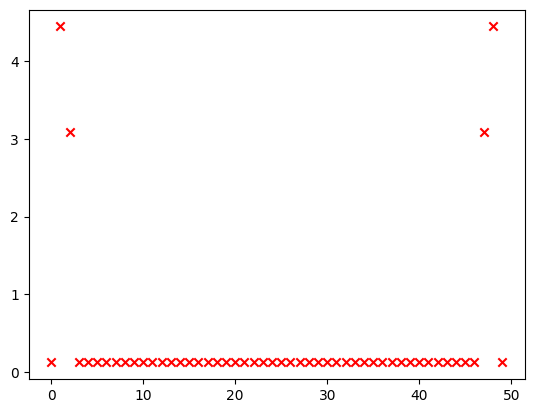

In [326]:
plt.scatter(range(nx), np.abs(c), c='red', marker='x') 

In [327]:
rec = fourier_reconstuction(x, range(nx), c)

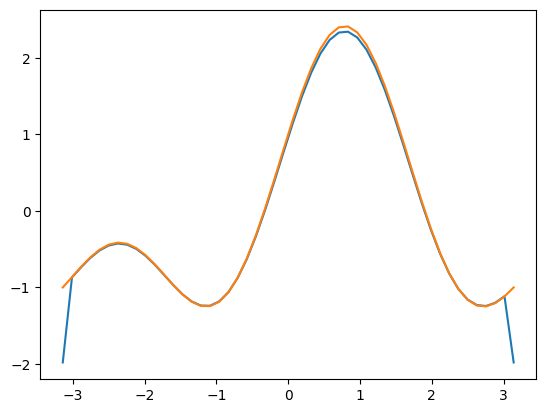

In [328]:
plt.plot(x, rec) 
plt.plot(x, g_h)

## Calcul des modes en $l=0$ 

Pour la résolution de l'équation de Poisson nous avons vu que nous étions intéressé par les coefficients de fourier 

$$c_{k,0}(f) = \int_{(-\pi, \pi)^2} f(x,v) \, e^{-i k .x} \,\text{d}x\,\text{d}v.$$ 

Nous les approchons numériquement de manière classique avec des sommes de Riemann : 

\begin{align*}
c_{k,0}(f) \sim & \Delta x\,\Delta v \sum\limits_{m=0}^{n_x -1}\sum\limits_{n=0}^{n_v -1} f[m, n]\, e^{-ik.x_m} \\
\sim & \frac{4\pi^2}{n_x\,n_v} \sum\limits_{m=0}^{n_x -1}\sum\limits_{n=0}^{n_v -1} f[m, n]\, e^{-ik.x_m},
\end{align*}  

Où l'on a écrit $\Delta x = \frac{2\pi}{n_x}$ et $\Delta v = \frac{2\pi}{n_v}$.  

In [329]:
def coeff_l_zero(x, v, k, f):
    nx = len(x); nv=len(v) 
    return ((4 * np.pi**2) / (nx*nv)) * np.sum([f[m,n] * np.exp(-1j*k*x[m]) for m,n in np.ndindex((nx, nv))])

def coeffs_l_zero(x, v, k_values, f):
    return np.array(list(map(lambda k: coeff_l_zero(x, v, k, f), k_values)))

In [330]:
import itertools as it 

## Code pour la résolution de Poisson 

Tous les éléments sont ainsi en place afin de résoudre l'équation de Poisson grâce aux séries de fourier 

In [382]:
def solve_poisson(x, v, k_values, f):
    nx = len(x) 
    F = build_F_tilde(x, k_values)
    c = coeffs_l_zero(x, v, k_values, f)
    c_tilde = np.zeros(len(k_values), dtype=complex)
    c_tilde[0] = 1 - c[0] 
    for k in range(1, len(k_values)):
        c_tilde[k] = - c[k]      
    d = np.zeros(len(k_values), dtype=complex)
    # Electric field mean has to be fixed
    d[0] = 0 
    for k in range(1, len(k_values)):  
        d[k] = (c_tilde[k]) / (k*1j)
    _E = fourier_reconstuction(x, k_values, d)
    return _E

In [383]:
E_zero = solve_poisson(x, v, range(nx), f_zero)

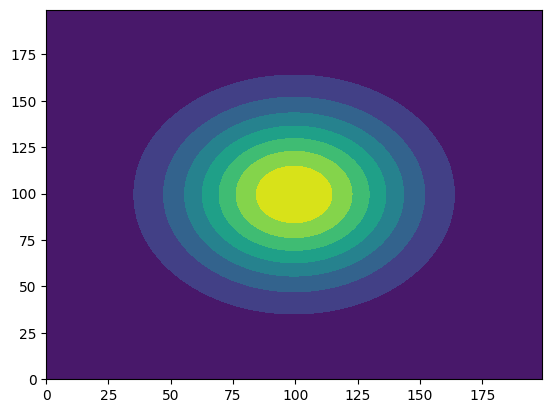

In [384]:
plt.contourf(f_zero) 

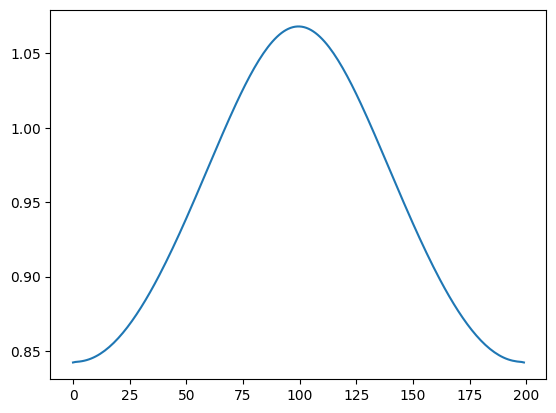

In [385]:
plt.plot(np.abs(E_zero)) 

## Phénomènes de transport dans l'équation de Vlasov


L'équation de Vlasov peut être décomposée en deux phénomènes décrivant son évolution :
- une advection en $v$ causée par le champ $E$ : 

\begin{equation}
\tag{a}
\partial_t f - E(x,t) \, \partial_v f = 0 
\end{equation}

- une advection en $x$ causée par le champ de vitesses : 

\begin{equation}
\tag{b}
\partial_t + v \,\partial_x f = 0
\end{equation}

Ces équations sont des équations de transport, dont les solutions analytiques peuvent être obtenues en appliquant la "méthode des caractéristiques".


### Méthode des caractéristiques



On considère une équation de transport 1D homogène à une dimension avec champ de vitesse $a(x,t)$: 

\begin{equation}
\tag{T}
\partial_t u + a(x,t)\,\partial_x u = 0
\end{equation}

Soit $(t,x) \in \mathbb{R}^{+} \times \mathbb{R}$ et  $X(s;t,x), s\in \mathbb{R}$ une courbe paramétrée lisse telle que $X(t;t,x) = x$.

On effectue le calcul de $\frac{d}{ds}u(X(s;t,x), t)$. 

\begin{align*} 
    \frac{\text{d}}{\text{d}s}u(X(s;t,x), s) = \partial_t u(X(s;t,x), s) + \frac{\text{d}X}{\text{d}s}(s;t,x)\, \partial_x u(X(s;t,x),s) & \quad \text{ (règle de la chaine)} 
\end{align*} 

On voit donc avec $(\text{T})$ que cette égalité se réduit à zéro si on impose la condition 

\begin{equation}
\tag{C}
\frac{\text{d}X}{\text{d}s} (s; t,x) = a(X(s;t,x),s) 
\end{equation}

On a ainsi réduit la résolution de l'EDP $(\text{T})$ à la résolution de l'EDO $(\text{C})$ dite "équation des caractéristiques". 


Dans le cas simple où le champ de vitesses $a$ est constant, l'équation $(\text{C})$ s'intégre en 
$$X(s;t,x) = as + b$$ 

et le coefficient b est déterminé par la condition

$$X(t;t,x) = x \implies b = x - at$$ 

de sorte que 

$$X(s;t,x) = x + a(s-t).$$

L'intérêt d'imposer l'équation des caractéristiques $\text{(C)}$ est de fixer 

$$\frac{\text{d}}{\text{d}s}u(X(s;t,x), s)= 0$$

et ainsi $\textbf{la solution est constante le long des courbes caractéristiques}$ de sorte que pour tout $(x,t)$

$$u(x,t) = u(X(t;t,x), t) = u(X(0;t,x), 0) = u_0(x-at)$$ 

où $u_0(x) = u(x, t=0)$ est la condition initiale. 



On voit ainsi ques les équations $(a)$ et $(b)$ sont analytiquement résolues par 

\begin{equation}
\tag{a*}
    f(x,v,t) = f_0(x, v + E(x)\,t)
\end{equation}
et
\begin{equation}
\tag{b*}
    f(x,v,t) = f_0(x - v\,t, v)
\end{equation}
respectivement. 

Seulement dans notre cas où l'on cherche à résoudre l'équation de Vlasov-Poisson (où l'évolution du champ électrique $E$ est couplée à l'équation de Vlasov) nous faison face à deux difficultés : 

1) Quel champ $E$ utiliser dans l'étape d'advection en $v$ ? Celui-ci évolue en effet simultanément par rapport à $f$. Cette question va nous amener à définir un schéma de $\textbf{splitting}$.
2) Les points $x-v\,t$ ou $v + E(x)\,t$ n'ont aucune raison particulière d'appartenir au maillage $\mathcal{M}$. Ce qui va nous amener à définir une étape $\textbf{d'interpolation}$ dans le schéma. 

## Interpolation en séries de Fourier 

On suppose connus la décomposition en série de fourier tronquée de $f$ à l'étape $n$ selon : 

$$ f^n(x, v) = \frac{1}{4\pi^2}\sum\limits_{k= -K}^{K}\sum\limits_{l = -L}^L c_{k,l}^n \, e^{i k.x}e^{i l.v} $$ 

L'interpolation consiste ainsi à évaluer cette expression aux points d'interpolation $x - v\Delta t$ ou $v + E(x)\frac{\Delta t}{2}$ par exemple. 

## Calcul des coefficients de fourier en 2D 

On voit ainsi qu'on a besoin de calculer les coefficients de fourier de $f$ dans les deux dimensions $(x,v)$ pour réaliser l'interpolation. On introduit donc de même le paramètre $L$.

In [335]:
K = 50
k_values = np.arange(-K, K+1) 
L = K 
l_values = np.arange(-L, L+1) 

De manière similaire à ce qui a été fait en dimension 1 on calcule les coefficients de fourier en 2D en résolvant un système matriciel qui peut s'écrire : 

$$ 
\begin{pmatrix}
c_{-K, -L} &  \cdots & c_{-K, L} \\ 
\vdots   & & \vdots \\ 
c_{K, -L} & \cdots & c_{K, L} 
\end{pmatrix}
= 
\frac{4\pi^2}{n_x\,n_v}
\tilde{F}^{2D} : 
\begin{pmatrix}
f_{0,0} & \cdots & f_{0, n_v-1} \\ 
\vdots &  & \vdots \\ 
f_{n_x -1, 0} & \cdots & f_{n_x-1, n_v-1} 
\end{pmatrix}
$$

Où $\tilde{F}^{2D}\in\mathbb{R}^{(2K+1) \times (2L+1) \times n_v \times n_x}$ est le tenseur d'ordre 4 défini par 

$$ \tilde{F}^{2D} = [ e^{-ik.x_n}e^{-il.v_m}]_{\,k,l,m,n}  \quad k=-K,\cdots,K;\, l=-L, \cdots, L;\, m=0,\cdots, n_v-1;\, n=0, \cdots, n_x-1$$ 



In [336]:
def build_F_tilde_2D(x, v):
    F_tilde = np.array([ np.exp(-k*1j*x[m])*np.exp(-l*1j*v[n]) for k,l,m,n in it.product(range(nx), range(nv), range(nx), range(nv))], dtype=complex)
    F_tilde.resize((nx, nv, nx, nv)) 
    return F_tilde

In [337]:
def fourier_coeffs_2D_tensor(x, v, f, F_tilde):
    return ((4*np.pi**2) / (nx*nv)) * np.tensordot(F_tilde, f) 

## Complexité trop élevée : introduction de la FFT 

La FFT (pour Fast Fourier Transform) est un des algorithmes les plus utilisés de nos jours en ceci que - comme son nom l'indique - il permet d'effectuer une transformée de Fourier (Discrète) très rapidement.

 Plus exactement sa complexité est un $O(N\log(N))$ contre $O(N^2)$ pour la transformée de Fourier "naïve". 

In [386]:
c_fft = np.fft.fft2(f_zero)

Par définition la FFT calcule la transformée de Fourier discrète du vecteur $f = [f(n)]_{n = 0, \cdots, \, N-1}$ selon 

$$ \text{FFT}(f)[k] = \sum\limits_{n=0}^{N-1} f[k]\, e^{-2i\pi kn/N}. $$

Ici, on va considérer le vecteur $\textbf{échantillonné}$ selon $\{f[n]\}_{n=0, \cdots, \,n_x-1} = \{f(x_n)\}$ où $x_n = - \pi + n \Delta x$ où $f$ est une fonction de la variable $x\in(-\pi, \pi)$.

Or nous sommes intéressés par le calcul des coefficients $c_k$ dans la série de Fourier de $f$, nous allons ainsi exprimer l'approximation en somme de Riemman de $c_k$ en faisant apparaître le terme $\text{FFT}(f)[k]$.


\begin{align*}
c_k(f)  = \mathcal{F}(f)(k) &= \int_{(-\pi, \pi)} f(x) e^{-ik.x}dx \\ 
                        &\sim \Delta x\,\sum\limits_{n=0}^{n_x-1} f(x_n)\, e^{-ikx_n} \quad \text{(Riemann)}\\ 
                        &\sim \Delta x\,\sum\limits_{n=0}^{n_x-1} f[n]\, e^{-ik(-\pi + n\Delta x)} \\
                        &\sim \frac{2\pi}{n_x} \,e^{ik\pi} \sum\limits_{n=0}^{n_x-1} f[n]\, e^{-2i\pi kn /n_x} \\ 
                        &\sim \frac{2\pi}{n_x} e^{ik\pi}\, \text{FFT}(f)[k].
\end{align*} 

On obtient ainsi les coefficients dans la série de Fourier de $f$ pour $k=0, \cdots, n_x-1$, et l'extension à $f$ définie sur deux dimensions $(x,v) \in (-\pi, \pi)^2$ pour notre cas d'étude est naturelle : 

$$ c_{k,l}(f) \sim \frac{4 \pi^2}{n_x\,n_v}\,e^{ik\pi}e^{il\pi}\,\text{FFT2}(f)[k,l] \quad \text{pour} \quad k = 0,\cdots, n_x-1;\, l=0,\cdots, n_v-1$$ 


In [387]:
def fourier_coeff_2D(x, v, f):
    nx = len(x); nv=len(v)
    c_fft = np.fft.fft2(f) 
    c = ((4*np.pi**2) / (nx*nv)) * np.array(
        [np.exp(k*1j*np.pi)*np.exp(l*1j*np.pi) * c_fft[k,l]
        for k,l in np.ndindex((nx,nv))]
        )
    c.resize((nx,nv)) 
    return c

In [388]:
c = fourier_coeff_2D(x, v, f_zero) 

In [389]:
c_fft = np.fft.fft2(f_zero) 
freqs = np.fft.fftfreq(nx) 

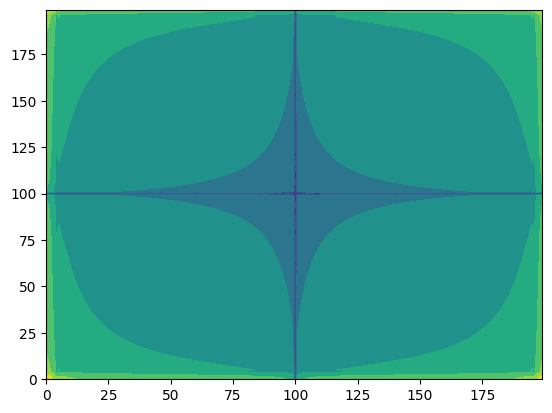

In [390]:
plt.contourf(np.log(np.abs(c_fft)))

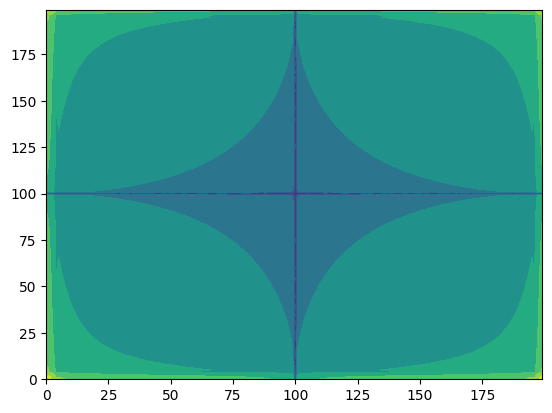

In [391]:
plt.contourf(range(nx), range(nv), np.log(np.abs(c)))

Ainsi la reconstruction de f à partir de sa série de fourier tronquée s'écrit 

$$ f(x,v) \sim \frac{1}{4 \pi^2} \sum\limits_{k=0}^{n_x -1}\sum\limits_{l=0}^{n_v-1} c_{k,l}(f) \, e^{ik.x}e^{il.v}.$$

In [344]:
def fourier_2D_interpolation(x, v, c):
    nx = len(x); nv = len(v) 
    reconstruction = lambda x : (1/(4*np.pi**2)) * np.sum(
        [c[k,l] * np.exp(k*1j*x[0]) * np.exp(l*1j*x[1]) for k,l in np.ndindex((nx, nv))]
    ) 
    return reconstruction 

In [347]:

interpol = fourier_2D_interpolation(x, v, c)    
f_inter = list(map(interpol, it.product(x,v))) 

In [392]:
m = np.random.random((1000, 1000)) 


In [393]:
s = np.einsum('ij->', m) 

In [394]:
s2 = np.sum(m) 

In [351]:
f_inter = np.array(f_inter)
f_inter.resize((nx, nv)) 

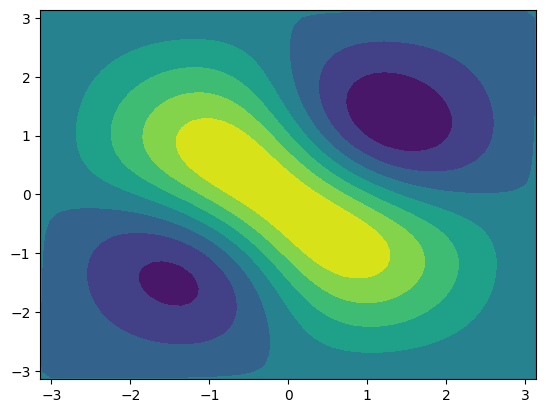

In [352]:
plt.contourf(x, v, f_inter)

## Schéma de Splitting semi-lagrangien

Nous détaillons ici le schéma de splitting que nous allons mettre en place pour la résolution du système de Vlasov-Poisson. 

1. $\textbf{Initialisation}$ : On se donne une condition initiale $f_0$, avec laquelle on calcule le champ initial $E_0$ en résolvant $(\text{P})$
2. $\textbf{Itération}$ : 
    - A partir de $(E^n, \,f^n)$ calculés à l'étape $n$ on calcule l'advection en $v$ sur un demi pas de temps $f^*(x,v) = f^n(x, v + E^n(x)\,\frac{\Delta t}{2})$ qui est solution de
        $$ \partial_t f - E^n(x)\,\partial_v f = 0.$$
        Les valeurs de $f^*$ étant obtenues par interpolation de $f^n$ selon la dimension $v$.

    - A partir de $f^*$ on calcule l'advection en $x$ sur un pas de temps complet $f^{**}(x,v) = f^*(x - v\,\Delta t, v)$ qui est solution de 
        $$ \partial_t f + v \,\partial_x f = 0.$$ 
        Les valeurs de $f^{**}$ étant également obtenues par interpolation de $f^{*}$ selon la dimension $x$.

    - On calcule le nouveau champ électrique $E^{n+1}(x)$ en résolvant $(\text{P})$ à partir de la distribution $f^{**}$.
    
    - Enfin, on effectue une dernière advection également avec une étape d'interpolation en $v$ à partir du nouveau champ électrique et de $f^{**}$ pour obtenir $f^{n+1}(x,v) = f^{**}(x, v+E^{n+1}(x)\,\frac{\Delta t}{2})$ qui est solution de 
        $$ \partial_t f - E^{n+1}(x)\,\partial_v f = 0.$$ 
    
    - On stocke $(f^{n+1}, \,E^{n+1})$.


## Interpolation 1D 

On voit ainsi dans le schéma qu'il n'est nécessaire de réaliser des interpolations qu'en une dimension selon si l'on souhaite calculer l'advection en $x$ ou en $v$ 

In [395]:
def x_fourier_interpolator(x, k_values, f, j):
    _f = f[:,j] 
    F = build_F_tilde(x, k_values)
    c = fourier_coeffs_1D(x, _f, F) 
    s = lambda x: (1 / (2*np.pi)) * np.sum([coeff*np.exp(1j*k*x) for k, coeff in zip(k_values, c)])
    return s 

def v_fourier_interpolator(v, l_values, f, i):
    _f = f[i,:] 
    F = build_F_tilde(v, l_values) 
    c = fourier_coeffs_1D(v, _f, F) 
    s = lambda v: (1 / (2*np.pi)) * np.sum([coeff*np.exp(1j*l*v) for l, coeff in zip(l_values, c)])
    return s

In [396]:
def build_x_interpolators(x, v, k_values, f):
    nv = len(v) 
    x_interpolators = [x_fourier_interpolator(x, k_values, f, j) for j in range(nv)] 
    return x_interpolators 

def build_v_interpolators(x, v, l_values, f):
    nx = len(x) 
    v_interpolators = [v_fourier_interpolator(v, l_values, f, i) for i in range(nx)]
    return v_interpolators  

## Code pour l'advection 

In [397]:
def local_x_advection(x, v, f, i, j, time_step, interpolators):
    ## Useless in the case of fourier interpolators 
    ## being intrinsically periodic
    _x = x[i]; _v = v[j] 
    x_tilde = _x - _v*time_step
    # Test cases to enforce periodic boundary conditions 
    if x_tilde < x[0]:
        # In case one steps out of the grid from the left 
        point = x[-1] - (x[0] - x_tilde) 
    elif x_tilde > x[-1]:
        # In case one steps out of the grid from the right 
        point = x[0] + (x_tilde - x[-1])
    else:
        point = x_tilde 
    return interpolators[j](point) 

def local_v_advection(x, v, f, i, j, time_step, _E, interpolators):
    ## Useless in the case of fourier interpolators 
    ## being intrinsically periodic 
    _x = x[i]; _v = v[j] 
    v_tilde = _v + _E[i]*time_step
    # Test cases for periodic boundary conditions 
    if v_tilde < v[0]:
        # In case one steps out of the grid from the left 
        point = v[-1] - (v[0] - v_tilde) 
    elif v_tilde > v[-1]:
        # In case one steps out of the grid from the right 
        point = v[0] + (v_tilde - v[-1])
    else:
        point = v_tilde 
    return interpolators[i](point) 

def x_advection(x, v, k_values, f, time_step):
    nx = len(x) ; nv = len(v) 
    x_interpolators = build_x_interpolators(x, v, k_values, f)
    new_f = [local_x_advection(x, v, f, i, j, time_step, x_interpolators) for i,j in np.ndindex((nx,nv))]
    new_f = np.array(new_f)
    new_f.resize((nx,nv)) 
    return new_f 

def v_advection(x, v, l_values, f, time_step, _E):
    nx = len(x) ; nv = len(v) 
    v_interpolators = build_v_interpolators(x, v, l_values, f) 
    new_f = [local_v_advection(x, v, f, i, j, time_step, _E, v_interpolators) for i,j in np.ndindex((nx,nv))]
    new_f = np.array(new_f)
    new_f.resize((nx, nv))
    return new_f

In [353]:
def advection_step(x, v, f, _E, time_step):
    c = fourier_coeff_2D(x, v, f) 
    interpol = fourier_2D_interpolation(x, v, c) 
    print("interpolation and fourier coeffs computed")
    inter_points = [(x[i] - time_step*v[j], v[j] + 0.5*time_step*_E[i])
        for i,j in np.ndindex((nx,nv)) 
    ]
    print("inter points computed") 
    f_star_two = np.array(list(map(interpol, inter_points))) 
    f_star_two.resize((nx,nv)) 
    print("f** computed") 
    new_E = solve_poisson(x, v, range(nx), f_star_two)  
    print("Poisson solved") 
    c_two = fourier_coeff_2D(x, v, f_star_two)
    interpol_two = fourier_2D_interpolation(x, v, c_two)
    inter_points = [(x[i], v[j] + 0.5*time_step*_E[i])
        for i,j in np.ndindex((nx, nv))
    ]
    print("inter points computed") 
    new_f = np.array(list(map(interpol_two, inter_points)))
    new_f.resize((nx,nv))
    print("new f computed") 
    return new_f, new_E 

# TROP LONG 


In [354]:
f_one = advection_step(x, v, f_zero, E_zero, time_step=0.01) 

interpolation and fourier coeffs computed
inter points computed
f** computed
Poisson solved
inter points computed
new f computed


In [398]:
l = [1 for i, j in np.ndindex((nx,nv))] 
print(len(l))
for i in range(10000):
    a = np.sum(l)

40000


In [399]:
_f, _E = f_one 
_f.resize((nx,nv)) 

ValueError: too many values to unpack (expected 2)

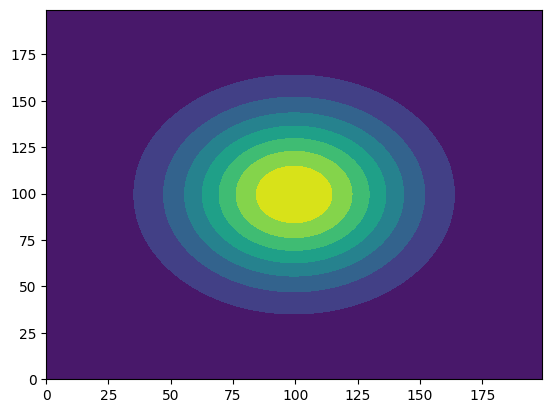

In [400]:
plt.contourf(f_zero) 

/home/murloc/.local/lib/python3.10/site-packages/numpy/ma/core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


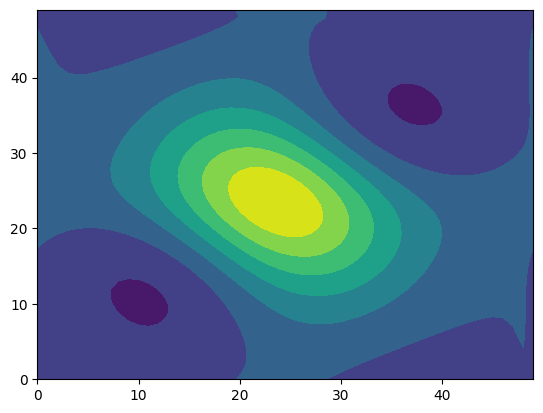

In [401]:
plt.contourf(_f) 

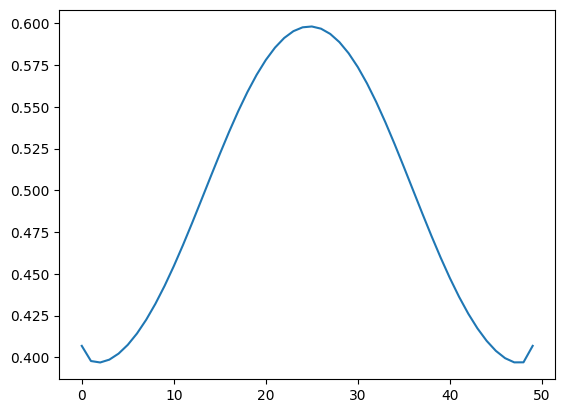

In [402]:
plt.plot(np.abs(_E))

In [403]:
## A OUBLIER POUR FOURIER, ON SE CONCENTRE SUR LES COEFFS EN 2D 
f_one = x_advection(x, v, range(nx), f_zero, 0.01)

In [404]:
f_two = v_advection(x, v, range(nv), f_zero, 0.01, E_zero)

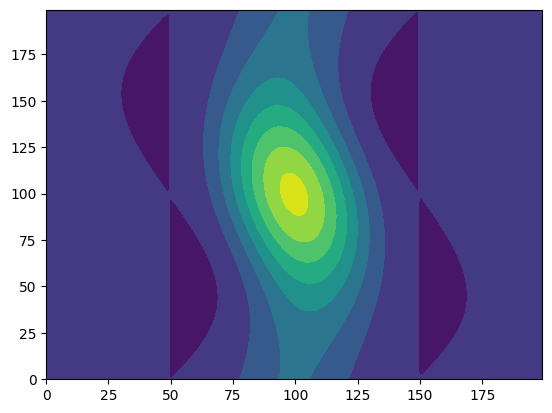

In [405]:
plt.contourf(f_one)

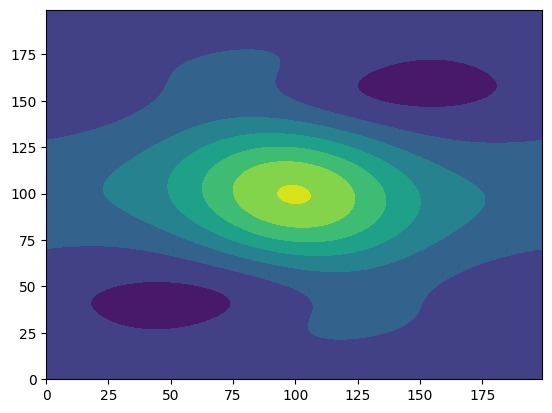

In [406]:
plt.contourf(f_two) 

In [ ]:
class semi_lagrangian_solver():

    def __init__(self, nx, nv, K, L, dt, a):
        self.dt = dt 
        self.nx = nx 
        self.nv = nv
        self.K = K 
        self.k_values = np.arange(-K, K+1) 
        self.L = L 
        self.l_values = np.arange(-L, L+1) 
        self.a = a 
        self.x = np.linspace(-a, a, nx)
        self.v = np.linspace(-a, a, nv)  
        self._E = None 
        self.f_zero = None 
        self.f = None 
        self.solutions = []
        self.electric_fields = [] 

    def initialisation(self, f):
        xx, vv = np.meshgrid(self.x, self.v)
        self.f_zero = f(xx, vv)   
        _E_zero = solve_poisson(self.x, self.v, self.k_values, self.f_zero) 
        self._E = _E_zero 
        self.f = self.f_zero 
        self.solutions.append(self.f_zero)
        self.electric_fields.append(_E_zero)

    def solve(self, n_steps):  
        for i in range(n_steps):
            f_star = v_advection(self.x, self.v, self.l_values, self.f, 0.5*self.dt, self._E)
            f_star_two = x_advection(self.x, self.v, self.k_values, f_star, self.dt) 
            new_E = solve_poisson(self.x, self.v, self.k_values, f_star_two)
            new_f = v_advection(self.x, self.v, self.l_values, f_star_two, 0.5*self.dt, new_E) 

            ## To try only transport with a fixed electric field 
            # new_f = x_advection(self.x, self.v, self.k_values, self.f, self.dt)
            # new_E = self._E
            
            self.f = new_f 
            self._E = new_E
            self.solutions.append(new_f) 
            self.electric_fields.append(new_E)
    
    def save_solutions(self, dir):
        for i, f in enumerate(self.solutions):
            plt.contourf(self.x, self.v, f)
            plt.xlabel(r'$x$'); plt.ylabel(r'$v$') 
            plt.title(r"$f$ at t={} s".format(i*self.dt))
            plt.savefig(dir + "f_{:03d}.png".format(i)) 

    def save_electric_field(self, dir): 
        for i, _E in enumerate(self.electric_fields):
            plt.plot(self.x, _E)
            plt.xlabel(r'$x$')
            plt.title(r"$E$ at t={}s".format(i*self.dt))
            plt.savefig(dir + "E_{:03d}.png".format(i))
    
    def track_dominant_fourier_mode(self): 
        self.dominant_mode = [] 
        for _E in self.electric_fields:
            c = np.abs(np.fft.fft(_E)) 
            c.sort() 
            self.dominant_mode.append(c[-1]) 
        

In [ ]:
solver = semi_lagrangian_solver(nx=200, nv=200, K=20, L=20, dt=0.01, a=np.pi)

array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
        -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
         6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20])

In [ ]:
solver.initialisation(f) 

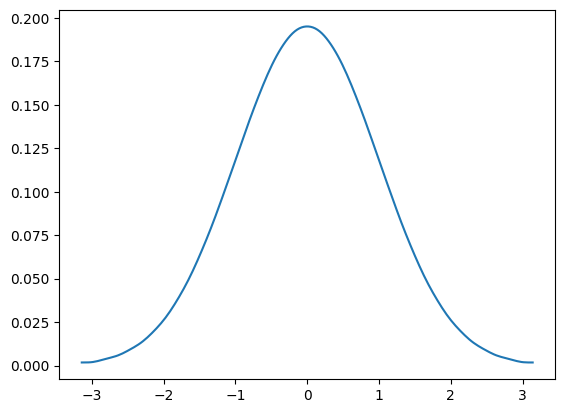

In [ ]:
np.shape(solver.f)
plt.plot(solver.x, np.abs(solver._E))


In [ ]:
solver.solve(n_steps=10)

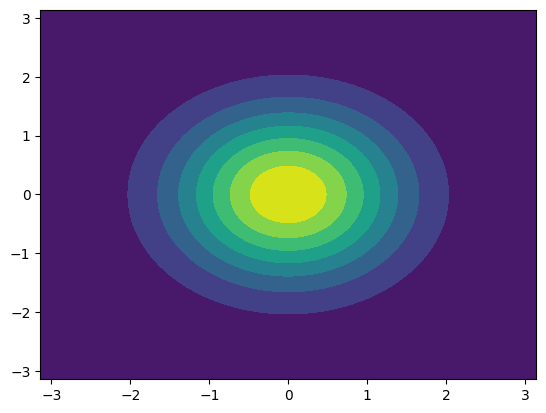

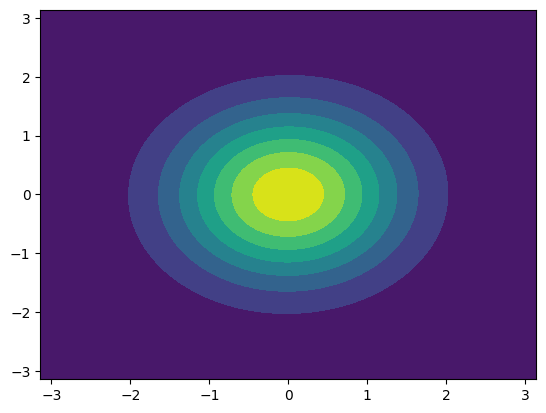

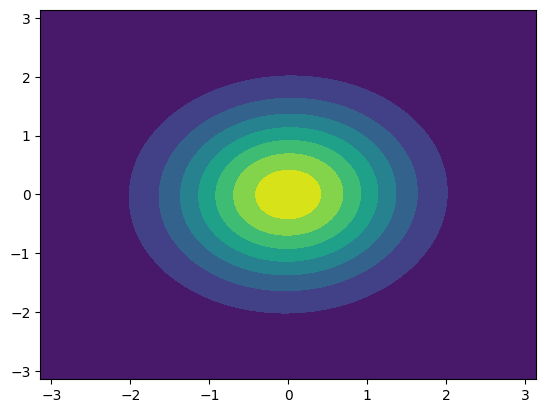

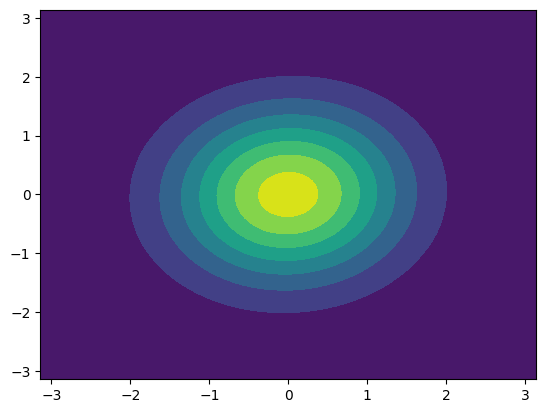

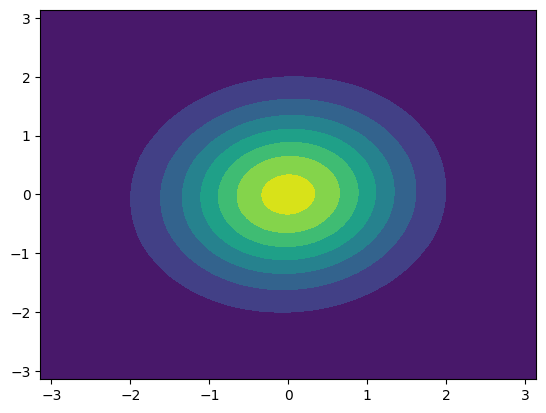

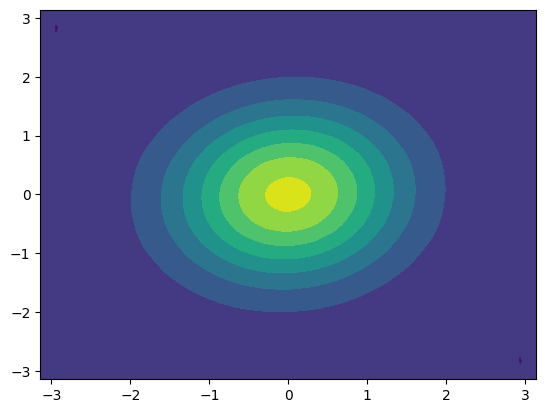

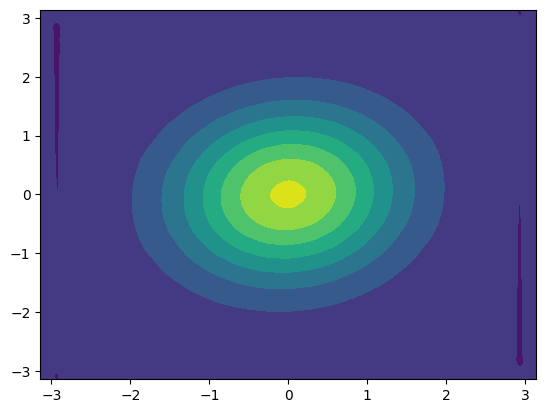

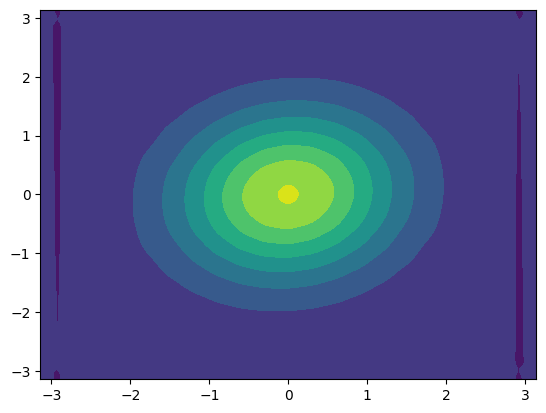

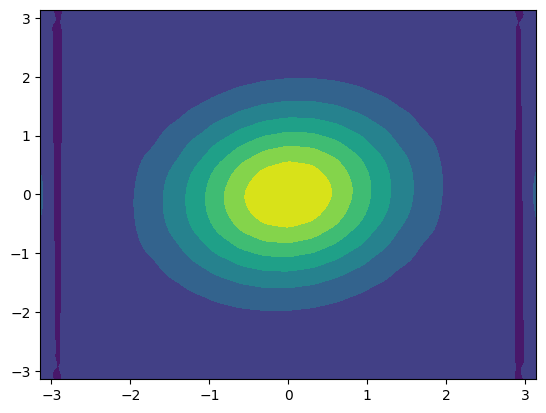

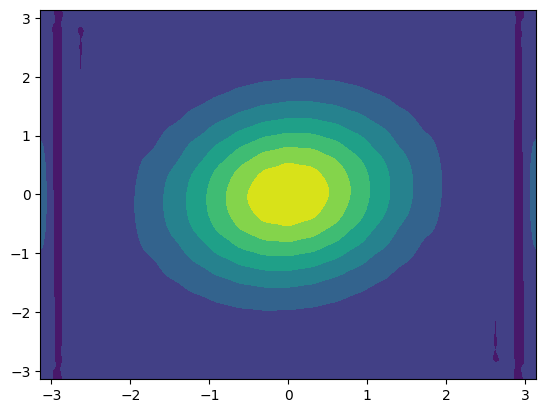

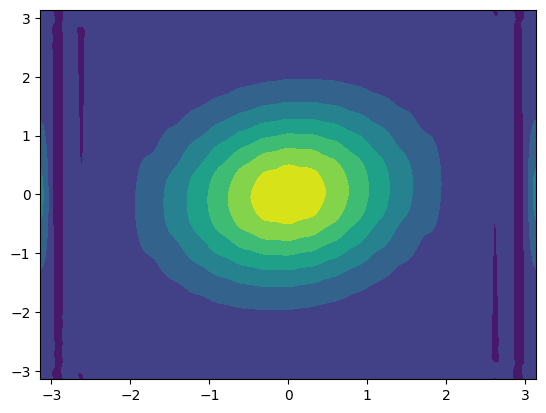

<Figure size 640x480 with 0 Axes>

In [ ]:
for sol in solver.solutions:
    plt.contourf(solver.x, solver.v, sol)
    plt.show()
    plt.clf() 
